In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load training data
X_train = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/train/features/cluster_features.csv')
y_train = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/train/labels/labels.npy')

# Load validation data
X_val = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/features/cluster_features.csv')
y_val = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/labels/labels.npy')

# Load test data (no labels)
X_test = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/features/cluster_features.csv')
test_ids = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/ids/ids.npy')


# Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Standardize features for logistic regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict on validation set
val_preds = logreg.predict_proba(X_val_scaled)[:, 1]
auc_score = roc_auc_score(y_val, val_preds)

print(f"Validation AUC for Logistic Regression: {auc_score:.4f}")


Validation AUC for Logistic Regression: 0.9444


In [4]:
# Saving validation set predictions
np.save('/kaggle/working/00_lr_val_preds.npy', val_preds)

# Predict probabilities on test set
test_preds = logreg.predict_proba(scaler.transform(X_test))[:, 1]

# Saving test set predictions
np.save('/kaggle/working/00_lr_test_preds.npy', test_preds)

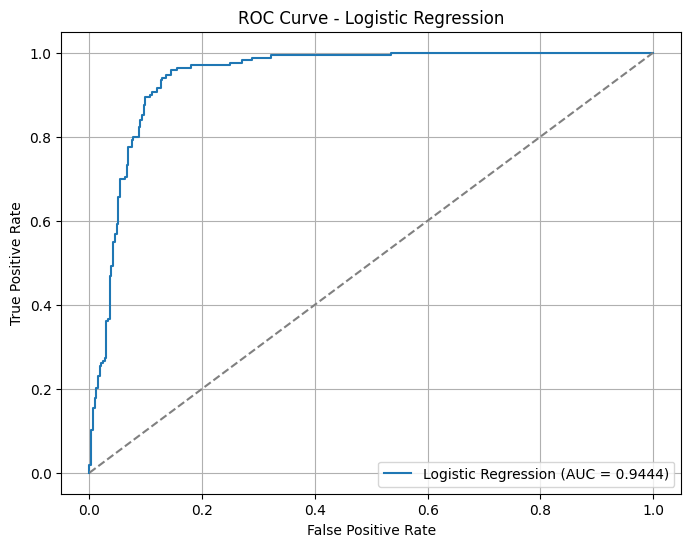

In [5]:
from sklearn.metrics import roc_curve

# Compute false positive rate, true positive rate, thresholds
fpr, tpr, thresholds = roc_curve(y_val, val_preds)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance - Logistic Regression

In [6]:
# Create a DataFrame of feature coefficients
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': logreg.coef_[0]
})

# Add absolute value for sorting
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()

# Sort by absolute importance
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

# Display top 15 important features
feature_importance.head(15)

,feature,coefficient,abs_coefficient
0,n_clusters,-2.107316,2.107316
11,mean_cluster_phi,1.582809,1.582809
7,total_pt,1.266147,1.266147
9,max_cluster_phi,1.214763,1.214763
2,mean_cluster_pt,-0.592721,0.592721
3,std_cluster_pt,-0.544767,0.544767
10,mean_cluster_eta,0.205665,0.205665
12,cluster_pt_ratio,0.167929,0.167929
8,max_cluster_eta,0.144155,0.144155
1,max_cluster_pt,0.000000,0.000000


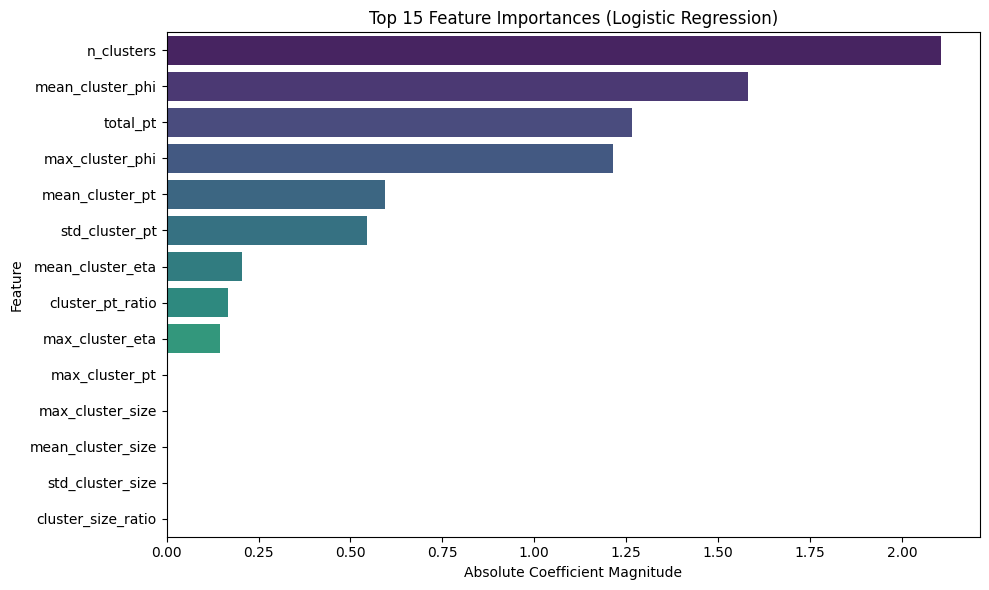

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='abs_coefficient', y='feature', palette='viridis')
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.xlabel("Absolute Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import pandas as pd

# Load test predictions and IDs
lr_test_preds = np.load('/kaggle/working/00_lr_test_preds.npy')
test_ids = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/ids/ids.npy')

# Create submission
lr_submission = pd.DataFrame({
    'id': test_ids,
    'label': lr_test_preds
})
lr_submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Logistic Regression submission saved: submission.csv")


Logistic Regression submission saved: submission.csv
